In [ ]:
%%capture
%pip install torchvision
%pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning

Mounted at /content/drive
/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning


In [ ]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import itertools
import random
import matplotlib.pyplot as plt
import os


from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.autograd import Variable
from torchvision import datasets, transforms
from itertools import zip_longest
from collections import deque

In [ ]:
torchvision.__version__

'0.18.0+cu121'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Create the folder if it doesn't exist
os.makedirs('pp_folder', exist_ok=True)

# Define a transform to convert the images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get a single image and its label
image, label = mnist[0]

# Print and save the single 1-channeled grayscale image
plt.imshow(image.squeeze(), cmap='gray')
plt.title("1-Channeled Grayscale Image")
plt.savefig('pp_folder/mnist_1_channel.png')
plt.close()

# Convert the 1-channeled grayscale image to a 3-channeled grayscale image
image_3channeled = image.repeat(3, 1, 1)

# Print and save each of the 3 channels separately
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(image_3channeled[i], cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
fig.savefig('pp_folder/mnist_3_channels.png')
plt.close(fig)


In [ ]:
# Create the folder if it doesn't exist
os.makedirs('pp_folder', exist_ok=True)

# Define a transform to convert the images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the SVHN dataset
svhn = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)

# Get a single image and its label
image, label = svhn[0]

# Print and save the single RGB image
plt.imshow(image.permute(1, 2, 0))
plt.title("RGB Image")
plt.savefig('pp_folder/svhn_rgb.png')
plt.close()

# Print and save each of the 3 channels as RGB
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    single_channel_image = torch.zeros_like(image)
    single_channel_image[i, :, :] = image[i, :, :]
    axs[i].imshow(single_channel_image.permute(1, 2, 0))
    axs[i].set_title(f'RGB Channel {i+1}')
fig.savefig('pp_folder/svhn_rgb_channels.png')
plt.close(fig)

# Print and save each of the 3 channels as grayscale
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(image[i], cmap='gray')
    axs[i].set_title(f'Grayscale Channel {i+1}')
fig.savefig('pp_folder/svhn_grayscale_channels.png')
plt.close(fig)

Using downloaded and verified file: ./data/train_32x32.mat


### Load MNIST dataset

In [ ]:
#model params
params = {
    'batch_size':128,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'mul': 250,
    'channels':3,
    'img_dim':32,
    'fliplr':True,
    'num_epochs':10,
    'decay_epoch':50,
    'lr':0.0002,    #learning rate for generator
    'num_classes':10
}


# Function to load and preprocess datasets
def load_dataset(dataset_cls, split, root, download, normalize=False, subset_size=None, batch_size=params['batch_size']):
    """
      Load and preprocess a dataset.
      :param dataset_cls: Dataset class (e.g., datasets.MNIST, datasets.SVHN)
      :param split: Data split ('train' or 'test')
      :param root: Root directory for dataset storage/download
      :param download: Flag to download the dataset if not present
      :param normalize: Flag to normalize the dataset
      :param subset_size: Size of the subset to use (if specified)
      :param batch_size: Batch size for DataLoader
      :return: DataLoader object
    """
    if dataset_cls == datasets.MNIST:
        dataset = dataset_cls(root=root, train=(split=='train'), download=download, transform=transforms.ToTensor())
    else:
        dataset = dataset_cls(root=root, split=split, download=download, transform=transforms.ToTensor())

    if normalize:
        # mean, std = compute_mean_and_std(dataset)

        if dataset_cls == datasets.MNIST:

            print(f"Dataset is MNIST: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim']) ),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])
        else:
            print(f"Dataset is SVHN: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim'] )),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])

        # Apply the computed normalization
        dataset.transform = transform

    if subset_size:
        indices = np.random.choice(len(dataset), subset_size, replace=False)
        print(dataset.transform)
        dataset = Subset(dataset, indices)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True if split == 'train' else False, num_workers=1)
    return loader

# Load MNIST datasets
mnist_trainloader = load_dataset(datasets.MNIST, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'] )
mnist_testloader = load_dataset(datasets.MNIST, 'test', './data/', True, normalize=True)

# Verify the sizes of the datasets
print(f'MNIST train subset size: {len(mnist_trainloader.dataset)}')


Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
MNIST train subset size: 32000


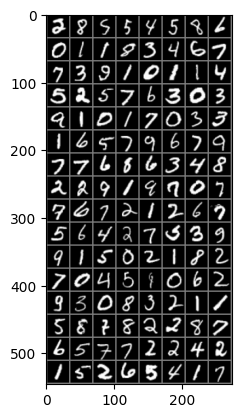

In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(mnist_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{dataiter.target[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from torch.utils.data import DataLoader, random_split
#### create val set
val_size = 10000
train_size = len(mnist_trainloader.dataset) - val_size
mnist_val, mnist_train = random_split(mnist_trainloader.dataset, [val_size, train_size]) # Split mnist_trainloader.dataset


val_loader = DataLoader(mnist_val, batch_size=params['batch_size'], shuffle=False)
test_loader = DataLoader(mnist_train, batch_size=params['batch_size'], shuffle=False)

### Training VGG-16 on MNIST

In [ ]:
# Define the VGG-16 architecture without pretrained weights
class VGG16Custom(nn.Module):
    def __init__(self, num_classes=params['num_classes']):
        super(VGG16Custom, self).__init__()
        # Load the VGG-16 model
        self.features = models.vgg16(weights=None).features
        # Modify the first convolutional layer to accept 1-channel input
        self.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        # Add a custom classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
vgg16 = VGG16Custom().to(params['device'])
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=params['lr'])


# Training loop with validation
for epoch in range(params['num_epochs']):
    vgg16.train()
    running_loss = 0.0
    for images, labels in mnist_trainloader:
        images, labels = images.to(params['device']), labels.to(params['device'])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{params["num_epochs"]}], Loss: {running_loss / len(mnist_trainloader):.4f}')

    # Validation step
    vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(params['device']), labels.to(params['device'])
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Evaluate the model on the test set
vgg16.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(params['device']), labels.to(params['device'])
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Loss: 0.6471
Validation Loss: 0.1074, Validation Accuracy: 96.60%
Epoch [2/10], Loss: 0.0812
Validation Loss: 0.0508, Validation Accuracy: 98.65%
Epoch [3/10], Loss: 0.0564
Validation Loss: 0.0359, Validation Accuracy: 98.96%
Epoch [4/10], Loss: 0.0371
Validation Loss: 0.0303, Validation Accuracy: 99.26%
Epoch [5/10], Loss: 0.0348
Validation Loss: 0.0175, Validation Accuracy: 99.45%
Epoch [6/10], Loss: 0.0354
Validation Loss: 0.0302, Validation Accuracy: 99.30%
Epoch [7/10], Loss: 0.0297
Validation Loss: 0.0164, Validation Accuracy: 99.58%
Epoch [8/10], Loss: 0.0203
Validation Loss: 0.0217, Validation Accuracy: 99.49%
Epoch [9/10], Loss: 0.0182
Validation Loss: 0.0087, Validation Accuracy: 99.77%
Epoch [10/10], Loss: 0.0195
Validation Loss: 0.0105, Validation Accuracy: 99.73%
Test Loss: 0.0101, Test Accuracy: 99.78%


#### Save the MNIST based trained VGG-16

In [ ]:
# # Save the trained model
torch.save(vgg16.state_dict(), 'model_checkpoints/3channeled_vgg16_mnist.pth')